**Description**: Tries to answer [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/q/611877/337906). Analyzes
datasets individually.

**Estimated runtime**: ~10 sec.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import permutation_test
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

In [2]:
sns.set_theme(style="darkgrid")

# Load data

In [3]:
ACC_COLUMNS = ["base", "extra", "test"]

In [4]:
ACCURACIES_DIR = os.path.join("accuracies_from_paper", "gpt2")

_dfs = []
for dataset in sorted(os.listdir(ACCURACIES_DIR)):
    _df = pd.read_csv(os.path.join(ACCURACIES_DIR, dataset, "accuracies.csv"))
    _df["dataset"] = dataset
    _dfs.append(_df)
accuracy_df = pd.concat(_dfs).reset_index(drop=True)
accuracy_df = accuracy_df[["dataset", "num_classes", "majority"] + ACC_COLUMNS]
accuracy_df["num_classes"] = accuracy_df["num_classes"].astype(int)
accuracy_df

,dataset,num_classes,majority,base,extra,test
0,ag_news,4,0.290,0.575,0.550,0.585
1,ag_news,4,0.320,0.535,0.555,0.575
2,ag_news,4,0.315,0.490,0.470,0.510
3,ag_news,4,0.275,0.460,0.710,0.655
4,ag_news,4,0.290,0.475,0.610,0.585
...,...,...,...,...,...,...
695,yelp_review_full,5,0.230,0.245,0.260,0.315
696,yelp_review_full,5,0.230,0.305,0.340,0.340
697,yelp_review_full,5,0.235,0.295,0.340,0.340
698,yelp_review_full,5,0.225,0.220,0.195,0.260


# Analysis

Below are the distributions of $\text{acc}_{\text{base}}$, $\text{acc}_{\text{extra}}$,
and $\text{acc}_{\text{test}}$, and the p-value corresponding to the following
statistical test:

$$
\begin{align*}
H_0&: \text{E}[\text{acc}_{\text{test}} - \text{acc}_{\text{extra}}] = 0 \\
H_1&: \text{E}[\text{acc}_{\text{test}} - \text{acc}_{\text{extra}}] > 0.
\end{align*}
$$

The p-value is estimated via permutation testing. It's then adjusted to control the
false discovery rate.

In [5]:
def _plot_histograms(
    dataset: str,
    df: pd.DataFrame,
    num_classes: int,
    majority_accuracy: float,
    bins: int | str = 10,
    show_majority_accuracy_legend: bool = False,
):
    fig, axes = plt.subplots(
        nrows=len(df.columns), ncols=1, figsize=(6, len(df.columns) * 1.5)
    )
    axes: list[plt.Axes]
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    ylim = (0, 20)
    # Plot histograms for each column
    for i, column in enumerate(df.columns):
        ax = axes[i]
        ax.hist(df[column], bins=bins, range=(0, 1), color=colors[i])
        ax.set_ylim(ylim)
        ax.set_xlabel(f"{column} accuracy")
        ax.set_ylabel("frequency")
        if show_majority_accuracy_legend:
            # option 3 from here: https://stackoverflow.com/a/4701285/18758987
            vline_label = "majority accuracy" if i == len(df.columns) - 1 else None
        else:
            vline_label = None
        ax.axvline(majority_accuracy, *ylim, label=vline_label, color="k")
        if show_majority_accuracy_legend:
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    if show_majority_accuracy_legend:
        fig.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig.suptitle(f"Dataset: {dataset}, # classes = {num_classes}", fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(hspace=1.2)

In [6]:
def individual_analysis(
    dataset: str, df: pd.DataFrame, num_classes: int, majority_accuracy: float
) -> float:
    # print("Summary statistics")
    # print(df.describe().round(3))
    # print()

    p_value: float = permutation_test(
        data=(df["test"], df["extra"]),
        statistic=lambda x, y: np.mean(x - y),
        alternative="greater",  # acc_test (unfair) > acc_extra (fair)
        permutation_type="samples",  # paired observations
        n_resamples=10_000,
    ).pvalue
    # print(f"p-value: {p_value}")
    # print()

    _plot_histograms(dataset, df, num_classes, majority_accuracy)

    return p_value

In [7]:
def analyze_all_separately(accuracy_df: pd.DataFrame) -> list[float]:
    return [
        individual_analysis(
            dataset,
            df[ACC_COLUMNS],
            int(df["num_classes"].iloc[0]),
            df["majority"].iloc[0],
        )
        for dataset, df in accuracy_df.groupby("dataset")
    ]

Black vertical line is majority accuracy

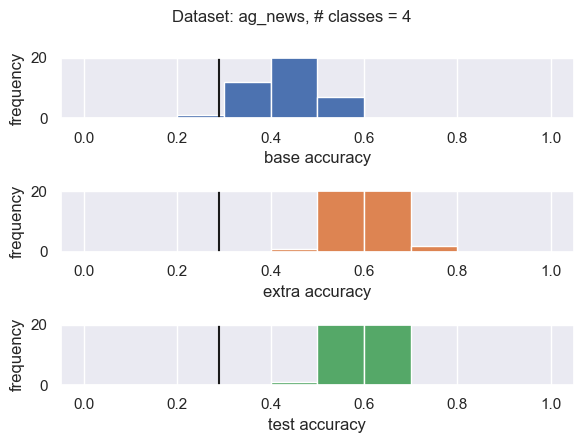

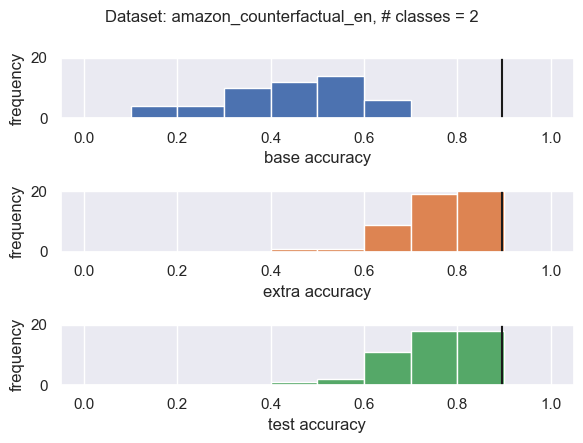

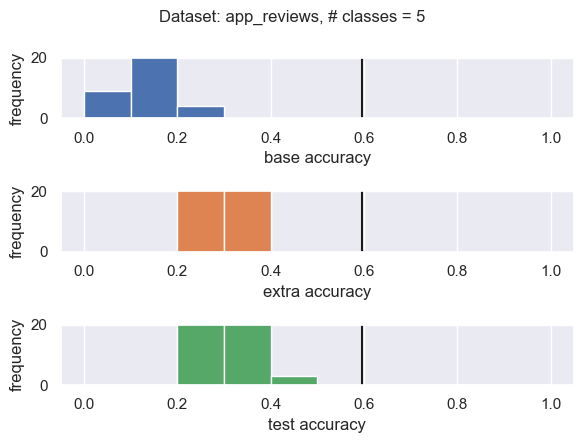

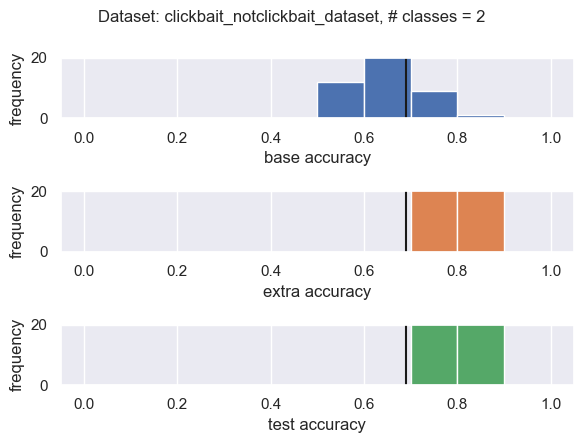

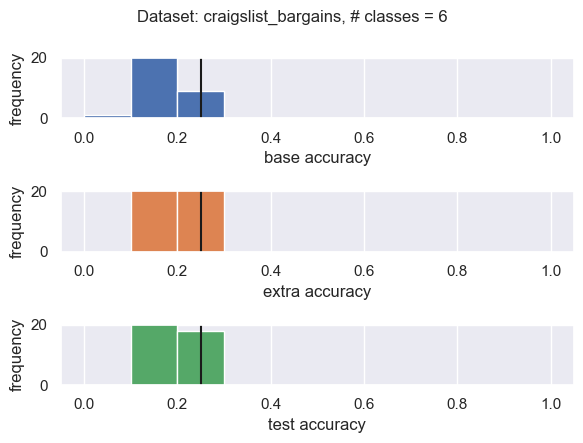

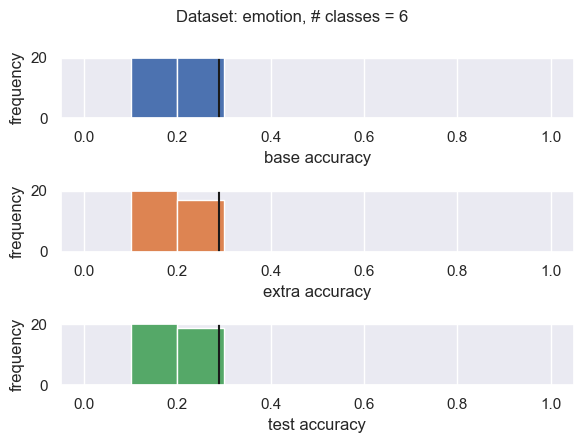

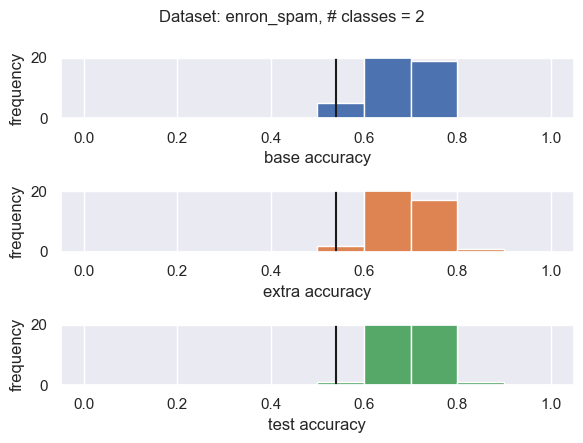

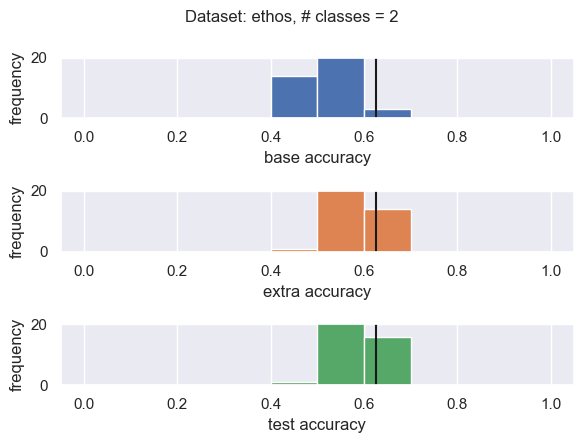

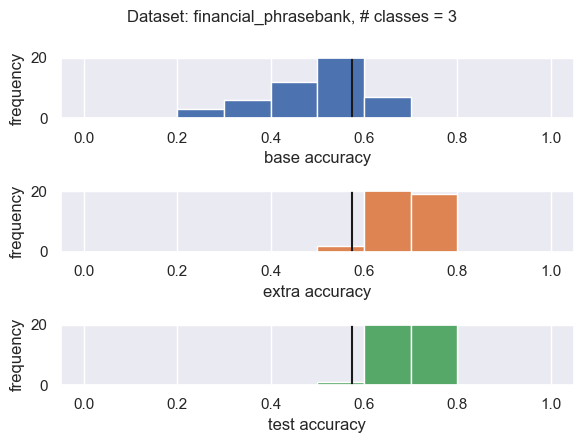

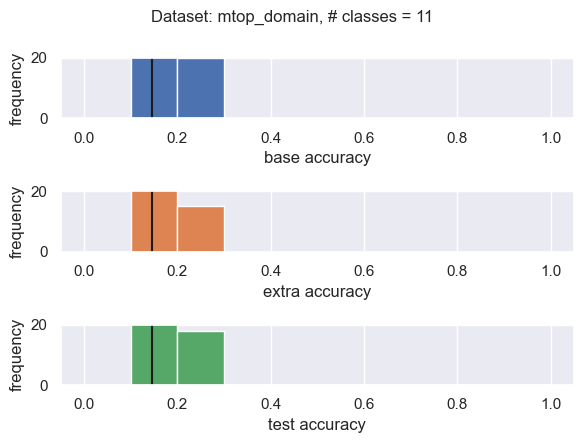

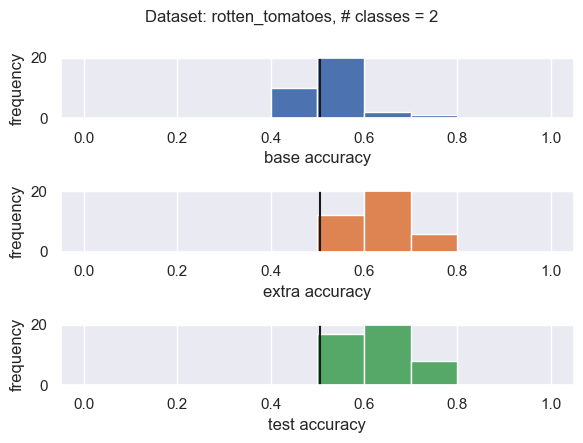

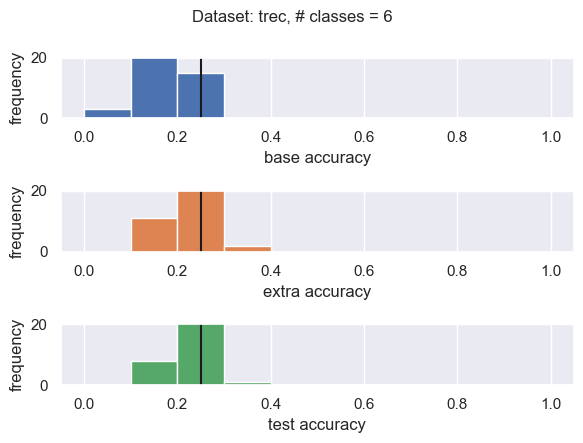

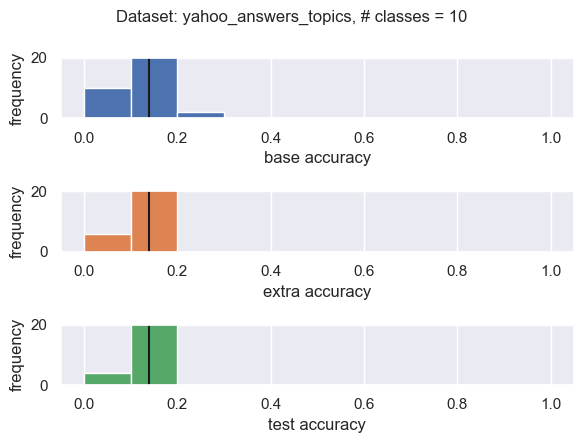

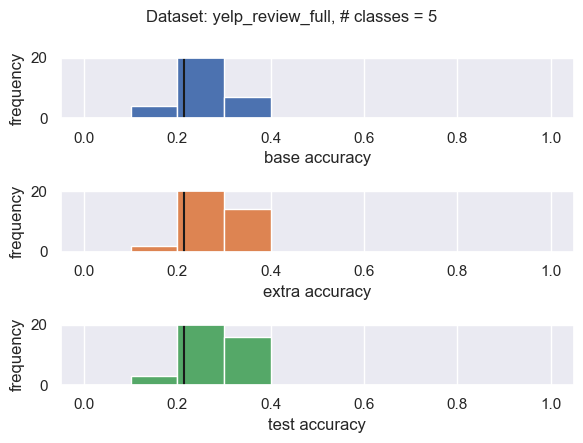

In [8]:
p_values = analyze_all_separately(accuracy_df)

In [9]:
p_values_adjusted = pd.Series(
    dict(zip(accuracy_df["dataset"].unique(), fdrcorrection(p_values)[1]))
)
p_values_adjusted.round(3)

ag_news                           0.234
amazon_counterfactual_en          0.959
app_reviews                       0.234
clickbait_notclickbait_dataset    0.742
craigslist_bargains               0.907
emotion                           0.742
enron_spam                        0.234
ethos                             0.723
financial_phrasebank              0.234
mtop_domain                       0.310
rotten_tomatoes                   0.907
trec                              0.234
yahoo_answers_topics              0.234
yelp_review_full                  0.709
dtype: float64

Note: after adjustment, it's wrong to interpret 1 - p the same way we would an
unadjusted p-value.